<a href="https://colab.research.google.com/github/Sreya0/BirdCo--Bird-Classification-by-CNN/blob/main/Bird_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.layers import (
    Dense,
    Activation,
    Dropout,
    Flatten,
    Input,
    AveragePooling2D,
    BatchNormalization,
)
from keras.models import Model
from keras.utils import plot_model, np_utils
from keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    TensorBoard,
    LearningRateScheduler,
)
from matplotlib import pyplot as plt
from matplotlib import style
from time import time
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras import backend as K
from os.path import isfile, join
from os import rename, listdir, rename, makedirs
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.utils.generic_utils import get_custom_objects
from keras.regularizers import l2


In [ ]:
X = pd.read_csv('data/feature_martix.csv')
Y = pd.read_csv('data/label_matrix.csv')

In [ ]:
main_data = pd.concat([X, Y], axis=1)
main_data = main_data.reindex(np.random.permutation(X.index))
dfs = np.split(main_data, [312], axis=1)

In [ ]:
X = dfs[0]
Y = dfs[1]


In [ ]:
a = Y.values.reshape(11787)

In [ ]:
neww = tf.one_hot(a,200)

In [ ]:
sess = tf.Session()
Y = neww.eval(session=sess)

In [ ]:
batch_size = 100
lr = 0.0002
num_iters = 3300
K = 250
#L = 250
n = 11787
pkeep = tf.placeholder(tf.float32)

In [ ]:
x = tf.placeholder(tf.float32, shape=[None, 312])
Y_ = tf.placeholder(tf.float32, shape=[None, 200])

In [ ]:
w1 = tf.Variable(tf.truncated_normal([312, K], stddev=0.1))
b1 = tf.Variable(tf.ones([K]))

In [ ]:
w2 = tf.Variable(tf.truncated_normal([K, 200], stddev=0.1))
b2 = tf.Variable(tf.ones([200]))

In [ ]:
y1 = tf.nn.relu(tf.matmul(x, w1) + b1)
do1 = tf.nn.dropout(y1, pkeep)

In [ ]:
y = tf.nn.softmax(tf.matmul(do1, w2) + b2)

In [ ]:
cross_entropy = -tf.reduce_sum(Y_ * tf.log(y))

In [ ]:
is_correct = tf.equal(tf.argmax(Y_, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

In [ ]:
train_step = tf.train.AdamOptimizer(learning_rate=lr).minimize(cross_entropy)

In [ ]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [ ]:
aaa = []
mmm = []
ccc = []
att = []
testccc = []

In [ ]:
for i in range(num_iters):
    train_data = {x: X[0:8520], Y_: Y[0:8520], pkeep:0.75}

    sess.run(train_step, feed_dict=train_data)

    atr, c = sess.run([accuracy, cross_entropy], feed_dict=train_data)

    test_data = {x: X[7520:], Y_: Y[7520:], pkeep:1}
    at, ac = sess.run([accuracy, cross_entropy], feed_dict=test_data)

    aaa.append(atr)
    mmm.append(i)
    ccc.append(c)
    att.append(at)
    testccc.append(ac)

    if(i%100 == 0):
      print(i, atr, c)

print('Accuracy on training set is ', atr)

print('Accuracy on test set is', at)

In [ ]:
style.use('ggplot')
plt.plot(mmm,aaa,color='b',label='training')
plt.plot(mmm,att,color='r',label='testing')
plt.xlabel('Num Iters')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(mmm,ccc,color='b',label='training')
plt.plot(mmm, testccc,color='r', label='testing')

In [ ]:
plt.xlabel('Num Iters')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [ ]:
def build_inception_resnet_V2(
    img_shape=(416, 416, 3),
    n_classes=16,
    l2_reg=0.0,
    load_pretrained=True,
    freeze_layers_from="base_model",
):
    # Decide if load pretrained weights from imagenet
    if load_pretrained:
        weights = "imagenet"
    else:
        weights = None

    # Get base model
    base_model = InceptionResNetV2(
        include_top=False, weights=weights, input_tensor=None, input_shape=img_shape
    )

    # Add final layers
    x = base_model.output
    x = AveragePooling2D((8, 8), strides=(8, 8), name="avg_pool")(x)
    x = Flatten(name="flatten")(x)
    x = Dense(512, activation="swish", name="dense_1", kernel_initializer="he_uniform")(
        x
    )
    x = Dropout(0.25)(x)
    predictions = Dense(
        n_classes,
        activation="softmax",
        name="predictions",
        kernel_initializer="he_uniform",
    )(x)

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze some layers
    if freeze_layers_from is not None:
        if freeze_layers_from == "base_model":
            print("   Freezing base model layers")
            for layer in base_model.layers:
                layer.trainable = False
        else:
            for i, layer in enumerate(model.layers):
                print(i, layer.name)
            print("   Freezing from layer 0 to " + str(freeze_layers_from))
            for layer in model.layers[:freeze_layers_from]:
                layer.trainable = False
            for layer in model.layers[freeze_layers_from:]:
                layer.trainable = True

    return model


model_inception_resnet_v2 = build_inception_resnet_V2()
model_inception_resnet_v2.load_weights("../inception_resnet_images+crop.h5")


image_path = "../tests/"

y_pred = []
y_pred_irv = []
y_pred_new = []

for i in species:
    specie = join(image_path, i)

    files = listdir(specie)
    files.sort(key=lambda f: int("".join(filter(str.isdigit, f))))

    for file in files:

        img_path = join(specie, file)
        image = cv2.imread(img_path, 1)

        result = model_coco.detect([image], verbose=1)

        r = result[0]

        l = len(r["rois"])

        batches = []
        for j in range(l):
            if r["class_ids"][j] == 15:

                y1, x1, y2, x2 = r["rois"][j]

                crop = image[y1:y2, x1:x2]
                crop = cv2.resize(crop, (416, 416))

                batches.append(crop)

        batches = np.asarray(batches).astype("float32")
        batches /= 255

        if batches.shape[0] > 0:
            inception_v3_predictions = model_cropped_inception_v3.predict(batches)
            inception_renet_v2_predictions = model_inception_resnet_v2.predict(batches)

            flipped = []
            flipped_1 = []
            flip_final = []
            for i in range(batches.shape[0]):
                flip = np.flip(np.argsort(inception_v3_predictions)[i], axis=0)
                flip1 = np.flip(np.argsort(inception_renet_v2_predictions)[i], axis=0)
                flipped.append(flip[0])
                flipped_1.append(flip1[0])

            for a in range(len(flipped)):
                m1 = flipped[a]
                m2 = flipped_1[a]
                if (
                    inception_v3_predictions[0][m1]
                    > inception_renet_v2_predictions[0][m2]
                ):
                    flip_final.append(m1)
                else:
                    flip_final.append(m2)

            x = np.bincount(flip_final)

            maxi = np.argmax(x)

            y_pred += [maxi]

        else:
            im = cv2.resize(image, (416, 416))
            im = np.reshape(im, (1, 416, 416, 3))

            inception_v3_predictions = model_final_inception_v3.predict(im)
            inception_renet_v2_predictions = model_inception_resnet_v2.predict(im)

            maxi = np.argmax(inception_v3_predictions)
            maxi_1 = np.argmax(inception_renet_v2_predictions)

            y_pred += [maxi]
            y_pred_irv += [maxi_1]
            if (
                inception_v3_predictions[0][maxi]
                > inception_renet_v2_predictions[0][maxi_1]
            ):
                y_pred_new += [maxi]
            else:
                y_pred_new += [maxi_1]


np.save("./Y_test_predictions.npy", y_pred)

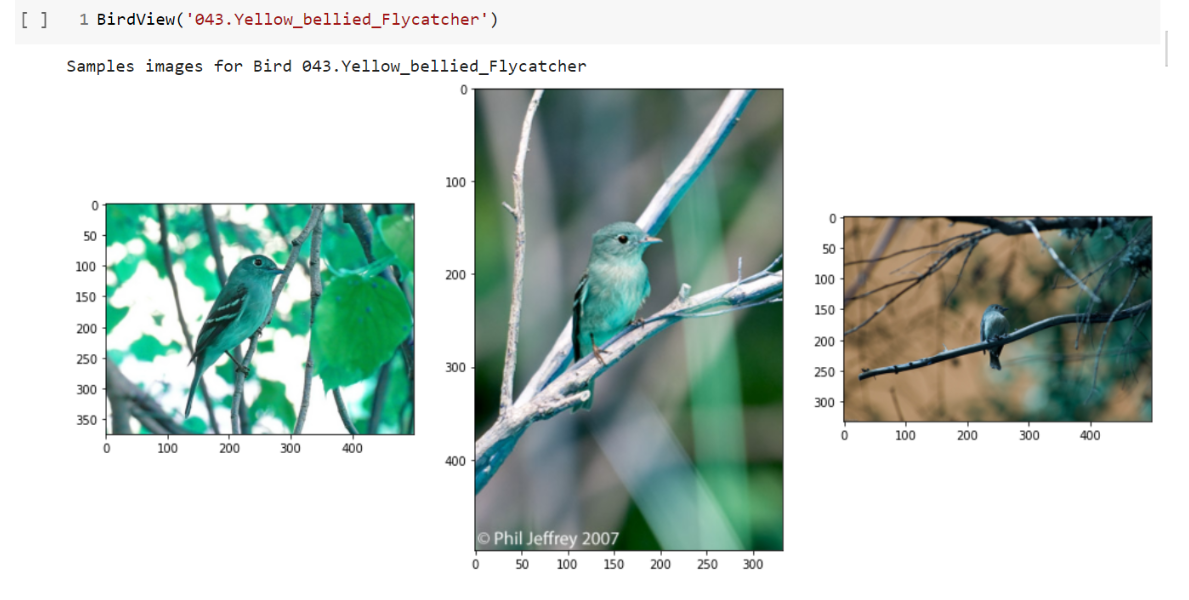